## Przygotowanie

Przed rozpoczęciem pracy z notatnikiem proszę zmienić jego nazwę dodając na początku numer albumu, imię i nazwisko.
{nr_albumu}\_{imię}\_{nazwisko}\_{nazwa}

Po wykonaniu wszystkich zadań proszę przesłać wypełniony notatnik przez TEAMS w wiadomości prywatnej.

## Regresja liniowa wieloraka

Rzadko kiedy zdarza się taka sytuacja, że zależność opisuje się na podstawie tylko jednej zmiennej. Z reguły na wynik zmiennej objaśnianej ($y$) ma wpły więcej różnych cech. Przykładowo, na cenę samochodu ma wpływ rok produkcji, przebieg, ilość koni mechanicznych itp. Dlatego właśnie jest naturalna potrzeba rozwinięcia algorytmu regresji liniowej z jedną cechą na większą ilość cech.

Algorytm, który implementowaliśmy w poprzednim zadaniu jest szczególnym przypadkiem regresji liniowej, ale może zostać on w łatwy sposób uogólniony. Mechanizmy, które poznaliśmy wcześniej takie jak obliczanie funkcji błędu, pochodnych cząstkowych, w dalszym ciągu są aktualne. Trzeba jedynie uwzględnić dodatkowe cechy.

### Zadanie 1

W zbiorze danych z zarobkami, który wykorzystywany był w poprzednim zadaniu, znajduje się pominięta wcześniej cecha. Wczytaj dane z pliku Salary.csv, tym razem z dwiema zmiennymi objaśniającymi: YearsExperience i Age oraz zmienną objaśnianą Salary. Stwórz wykres 3D przedstawiający dane.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./Salary.csv', sep=',')

df.head()

,YearsExperience,Age,Salary
0,1.1,20,39343
1,1.3,21,46205
2,1.5,21,37731
3,2.0,22,43525
4,2.2,22,39891


In [2]:
#from sklearn.preprocessing import MinMaxScaler

#cols = df.columns

#scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns = cols)

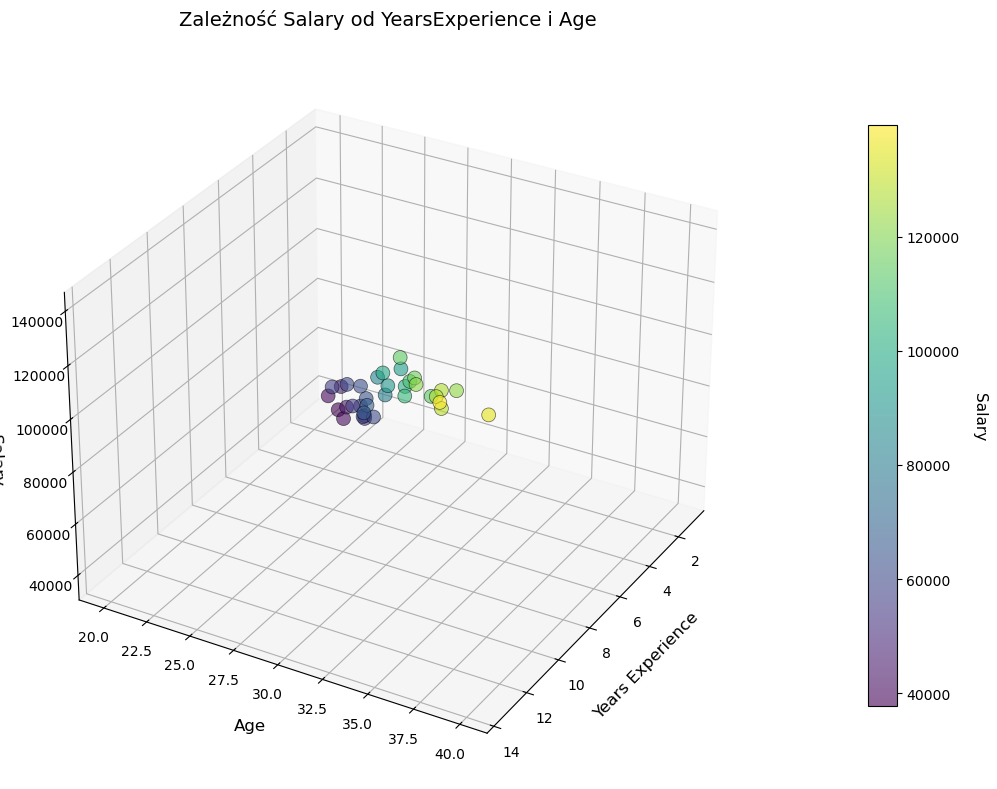

In [3]:
years_exp = df['YearsExperience'].values
age = df['Age'].values
salary = df['Salary'].values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(years_exp, age, salary, 
                     c=salary, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

ax.set_xlabel('Years Experience', fontsize=12, labelpad=10)
ax.set_ylabel('Age', fontsize=12, labelpad=10)
ax.set_zlabel('Salary', fontsize=12, labelpad=10)
ax.set_title('Zależność Salary od YearsExperience i Age', fontsize=14, pad=20)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Salary', rotation=270, labelpad=20, fontsize=11)

ax.view_init(elev=30, azim=30)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Zadanie 2

Przerób algorytm znajdujący się w funkcji _learn_and_fit(x,y)_ w taki sposób, aby uwzględniał dodatkową cechę.
Funkcja regresji liniowej przybierze w tym momencie postać:

\begin{equation}
f(x^{(i)}) = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 = \beta_{0} + \beta_{1} YearsExperience + \beta_{2} Age
\end{equation}

Pojawienie się kolejnej cechy wymaga akutalizacji obliczania gradientu. Należy dodatkowo obliczyć pochodną cząstkową względem parametru $\beta_{2}$, a następnie zaktualizować wartość tego parametru. 

Obliczenie pochodnej cząstkowej wygląda analogicznie jak w przypadku parametru $\beta_{1}$.

\begin{equation}
    \frac{\partial SSR}{\partial \beta_{2}} = \frac{1}{n} \sum^{n}_{i=1} (f(x^{(i)}) - y^{(i)})x_{1}^{(i)}
\end{equation}

Aktualizacja wartości współczynnika również jest analogiczna.

\begin{equation}
    \beta_{2} = \beta_{2} - \alpha \frac{\partial SSR}{\partial \beta_{2}} 
\end{equation}

_Uwaga: Zastanów się, w jaki sposób zaimplementować obługę kolejnych cech, tak aby po pojawieniu się 3 cechy nie trzeba było modyfikować algorytmu._

In [4]:
from typing import Tuple

def initialize_coefficients(n: int = 2, alpha = None) -> Tuple[float, np.ndarray]:
    if alpha is None:
        coefs = np.random.uniform(size=n+2)
        return coefs[0], coefs[1:]

    if not (0 <= alpha <= 1):
        raise ValueError(f"Alpha must be between 0 and 1, got {alpha}")

    betas = np.random.uniform(size=n+1)
    return alpha, betas


def calculate_regression_function(X: np.ndarray, betas: np.ndarray) -> np.ndarray:
    m = X.shape[0]
    X_with_intercept = np.column_stack([np.ones(m), X]) # adding columns with one for matrix multiplication 
    
    predictions = X_with_intercept @ betas
    
    return predictions

def calculate_error(predictions: np.ndarray, y: np.ndarray) -> float:
    m = y.size
    resid = predictions - y

    ssr = (resid.T @ resid) / (2 * m)
    return ssr

def calculate_gradient(predictions: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    m = y.size

    residuals = predictions - y
    
    X_with_intercept = np.column_stack([np.ones(m), X])
    gradients = (X_with_intercept.T @ residuals) / m # check if correct
    
    return gradients


def update_regression_coefficients(predictions: np.ndarray, X: np.ndarray, y: np.ndarray, betas: np.ndarray, alpha: float) -> np.ndarray:
    gradients = calculate_gradient(predictions, X, y)
    new_betas = betas - alpha * gradients
    
    return new_betas

In [5]:
'''
input:
X - wartości zmiennych objaśniających YearsExperience oraz Age dla wszystkich obserwacji
y - wartości zmiennej objaśnianej Salary dla wszystkich obserwacji

output:
betas: [] - lista z współczynnikami beta_0, beta_1, beta_2 w każdej z epok
error: [] - lista z błędem w każdej epoce
'''
def learn_and_fit(X: np.ndarray, y: np.ndarray, alpha: float = None, epoch: int = 100, threshold: float = 0.001) -> Tuple[np.ndarray, np.ndarray]:

    betas = []
    error = []

    n = X.shape[1]

    alpha, betas_v = initialize_coefficients(n, alpha)

    for i in range(epoch):
        betas.append(betas_v)

        predictions = calculate_regression_function(X, betas_v)

        err = calculate_error(predictions, y)
        error.append(err)

        if i > 0 and abs(error[i] - error[i-1]) / error[i-1] < threshold:
            break

        betas_v = update_regression_coefficients(predictions, X, y, betas_v, alpha)

    return (betas, error)

In [6]:
X = df[['YearsExperience', 'Age']].values
y = df['Salary'].values

In [7]:
betas, error = learn_and_fit(X, y, alpha=0.0022, epoch=1000, threshold=0.0001)

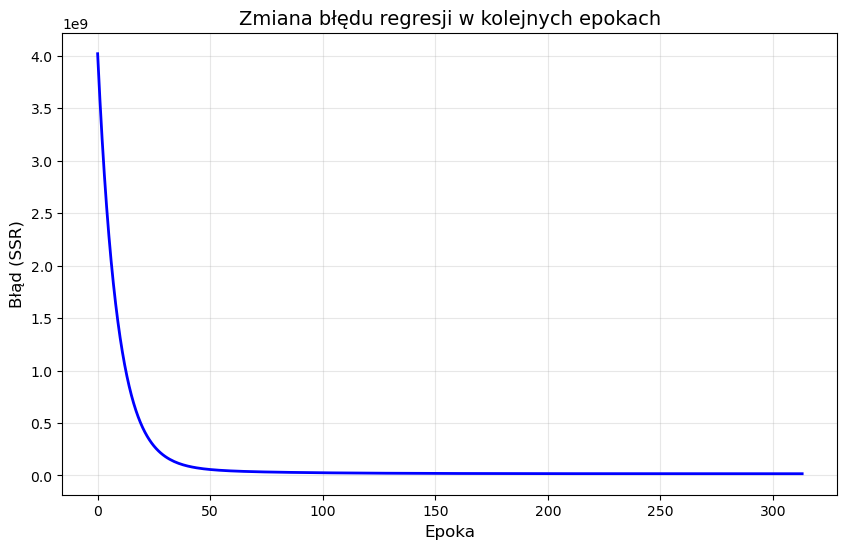

Początkowy błąd: 4019.92M
Końcowy błąd: 16.88M
Liczba epok: 314


In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, 'b-', linewidth=2)
plt.xlabel('Epoka', fontsize=12)
plt.ylabel('Błąd (SSR)', fontsize=12)
plt.title('Zmiana błędu regresji w kolejnych epokach', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Początkowy błąd: {error[0]/1e6:.2f}M")
print(f"Końcowy błąd: {error[-1]/1e6:.2f}M")
print(f"Liczba epok: {len(error)}")

### Zadanie 3

Do stworzonego z zadaniu 1 wykresu dodaj płaszczyznę regresji. Stwórz 3 wykresy przedstawiające jak zmieniała się funkcja regresji na przestrzeni epok (pierwsza, środkowa, ostatnia epoka).

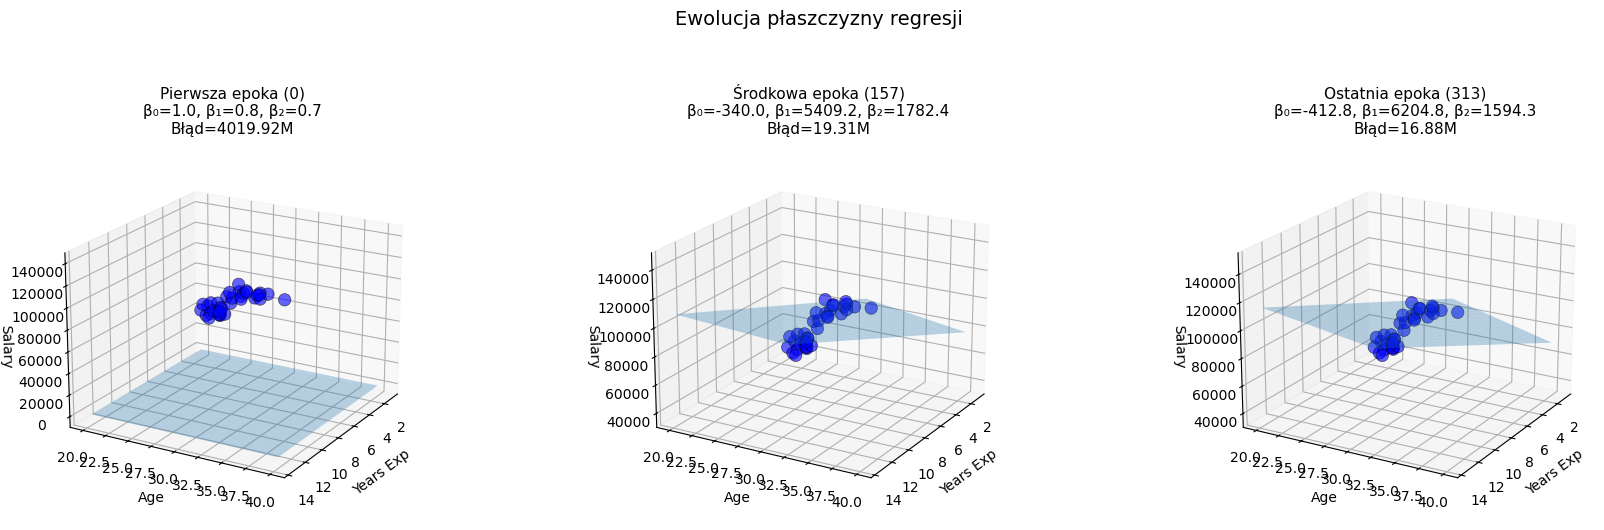

In [9]:
epochs_to_plot = [
    (0, 'Pierwsza'),
    (len(betas) // 2, 'Środkowa'),
    (len(betas) - 1, 'Ostatnia')
]

fig = plt.figure(figsize=(18, 5))

for idx, (epoch_idx, epoch_name) in enumerate(epochs_to_plot):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    
    betas_v = betas[epoch_idx]
    
    ax.scatter(X[:, 0], X[:, 1], y, 
               c='blue', 
               s=80, 
               alpha=0.6,
               edgecolors='black',
               linewidth=0.5)
    
    x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 15)
    x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 15)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    y_pred = betas_v[0] + betas_v[1] * x1_grid + betas_v[2] * x2_grid
    
    ax.plot_surface(x1_grid, x2_grid, y_pred, 
                   alpha=0.3,
                   edgecolor='none')
    
    ax.set_xlabel('Years Exp', fontsize=10)
    ax.set_ylabel('Age', fontsize=10)
    ax.set_zlabel('Salary', fontsize=10)

    ax.set_title(f'{epoch_name} epoka ({epoch_idx})\n' +
                 f'β₀={betas_v[0]:.1f}, β₁={betas_v[1]:.1f}, β₂={betas_v[2]:.1f}\n' +
                 f'Błąd={error[epoch_idx]/1e6:.2f}M',
                 fontsize=11)
    
    ax.view_init(elev=20, azim=30)

plt.suptitle('Ewolucja płaszczyzny regresji', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### Zadanie 4

W sytuacji, w której zbiór danych zawiera więcej zmiennych objaśniających niż 2, niemożliwym staje się wizualizacja prostej regresji i ocena w taki sposób stworzonego modelu. Bardzo przydatnym rozwiązaniem jest wtedy stworzenie wykresu błędów regresji. Jeśli wartości błędu spadają wraz z kolejnymi epokami, oznacza to, że jesteśmy na dobrej drodze, a nasz algorytm działa poprawnie. Celem tego zadania będzie stworzenie finalnego modelu regresji liniowej, który będzie przyjmował dowolną liczbę zmiennych objaśniających.

Na podstawie wcześniejszych implementacji, stwórz implementację funkcji *learn_and_fit_multi(X, y)*, która będzie przyjmować zbiór wejściowy z dowolną ilością kolum (cech). Dla takiego zbioru zbioru danych ma zostać stworzony model regresji. Funkcja podobnie jak wcześniej, ma zwracać współczynniki oraz wartość błędu w każdej epoce. 

W notebooku z opisem regresji liniowej przedstawione zostały wzory na ogólą postać regresji. Przeanalizuj je jeszcze raz i postaraj się je zaimplementować.

Wczytaj zestaw danych *multi_variable_regression.csv* z katalogu datasets. Dane wygenerowane zostały w taki sposób, że są wysoce liniowo zależne. Wartość błędu dla nauczonego modelu powinna być w takim przypadku niewielka. Przetestuj na wczytanym zbiorze swój algorytm.

In [40]:
data_multi = pd.read_csv("./multi_variable_regression.csv")
X_multi = data_multi[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']].values
y_multi = data_multi['y'].values

data_multi.head()

,x1,x2,x3,x4,x5,x6,y
0,-0.586479,0.457946,0.611877,1.234197,0.345695,0.574824,177.111999
1,-0.101979,-0.330872,0.391967,-0.238672,0.736806,-0.934582,-134.845687
2,-0.704671,-1.156918,0.510129,0.468877,0.402749,0.438787,-29.719439
3,-1.318963,1.030290,0.099815,0.395081,0.315859,-0.621132,-11.984118
4,-1.162739,-0.684766,-0.202388,0.726013,-0.093449,0.944595,47.913451


In [ ]:
# poprzednia implementacja umożliwia działanie z wieloma zmiennymi objaśniającymi

In [20]:
betas, error = learn_and_fit(X_multi, y_multi, alpha=0.5, epoch=1000, threshold=0.0001)

### Zadanie 5

Stwórz wykres przedstawiający zmianę błędu regresji w kolejnych epokach. Napisz co można na jego podstawie wywnioskować.

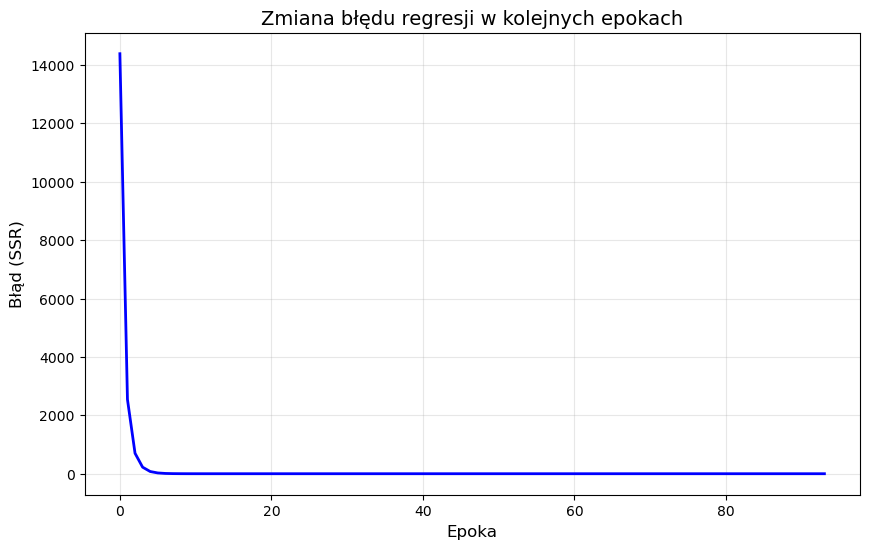

Początkowy błąd: 1.44E+04
Końcowy błąd: 4.56E-28
Liczba epok: 94


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, 'b-', linewidth=2)
plt.xlabel('Epoka', fontsize=12)
plt.ylabel('Błąd (SSR)', fontsize=12)
plt.title('Zmiana błędu regresji w kolejnych epokach', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Początkowy błąd: {error[0]:.2E}")
print(f"Końcowy błąd: {error[-1]:.2E}")
print(f"Liczba epok: {len(error)}")

#### Wniosek
Na podstawie wykresu można wywnioskować, że algorytm zbiega poprawnie, a błąd maleje z każdą epoką. Błąd bardzo szybko spada w pierwszych epokach, a następnie stabilizuje się w wartosci bardzo blieskiej zera, co sugeruje, że model osiąga optymalne dopasowanie do danych.

### Zadanie 6

W jaki sposób współczynnik alpha wpływa na działania algorytmu? Przeprowadź eksperyment dla minimum trzech różnych wartości tego parametru. Sformułuj wnioski. Jak zmiana parametru wpłynęła na ilość epok w algorytmie? Jak zmieniła się funkcja regresji?

Alpha = 0.1:
  Liczba epok: 490
  Końcowy błąd: 8.87E-27

Alpha = 0.5:
  Liczba epok: 94
  Końcowy błąd: 4.56E-28

Alpha = 0.8:
  Liczba epok: 68
  Końcowy błąd: 3.94E-28



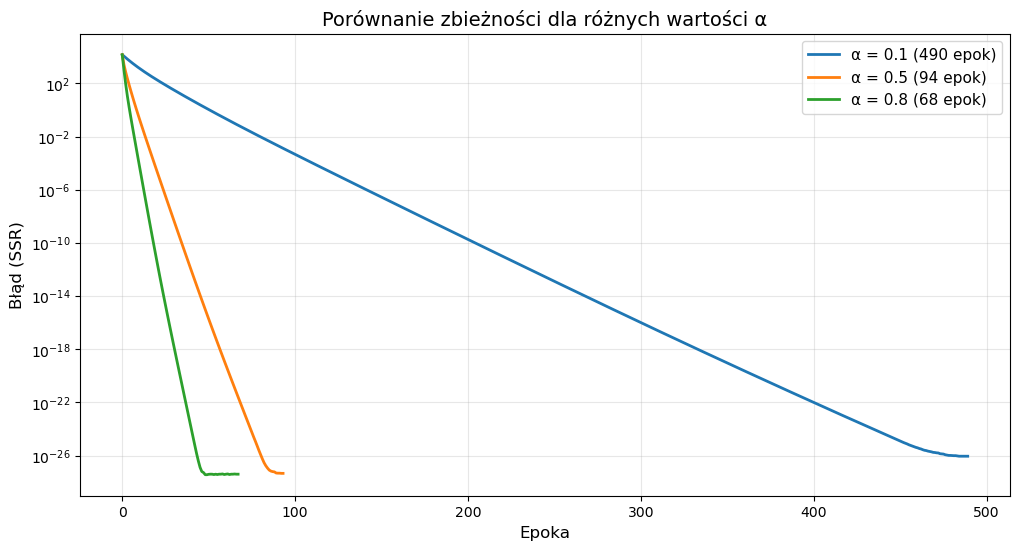

In [ ]:
alphas = [0.1, 0.5, 0.8]
results = {}

for alpha_val in alphas:
    betas_hist, error_hist = learn_and_fit(X_multi, y_multi, alpha = alpha_val, epoch = 1000)
    results[alpha_val] = {
        'epochs': len(error_hist),
        'final_error': error_hist[-1],
        'errors': error_hist,
        'b0': betas_hist[-1][0],
        'b1': betas_hist[-1][1],
        'b2': betas_hist[-1][2],
        'b3': betas_hist[-1][3],
        'b4': betas_hist[-1][4],
        'b5': betas_hist[-1][5],
        'b6': betas_hist[-1][6],
    }
    print(f"Alpha = {alpha_val}:")
    print(f"  Liczba epok: {results[alpha_val]['epochs']}")
    print(f"  Końcowy błąd: {results[alpha_val]['final_error']:.2E}")
    print()

plt.figure(figsize=(12, 6))

for alpha_val in alphas:
    errors = results[alpha_val]['errors']
    plt.plot(range(len(errors)), errors, linewidth=2, 
             label=f'α = {alpha_val} ({len(errors)} epok)')

plt.xlabel('Epoka', fontsize=12)
plt.ylabel('Błąd (SSR)', fontsize=12)
plt.title('Porównanie zbieżności dla różnych wartości α', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

#### Wnioski 
Współczynnik alpha ma istotny wpływ na szybkość zbieżności algorytmu.Im wyższa wartość alpha, tym szybciej algorytm zbiega do minimum błędu, jednak zbyt wysoka wartość może prowadzić do niestabilności i oscylacji wokół minimum. Optymalna wartość alpha pozwala na efektywne i stabilne uczenie modelu regresji. Dla optymalnych rezultatów warto jest zastosować normalizację cech wejściowych, szczególnie gdy mają one różne skale - pomoże to w stabilizacji procesu uczenia.

W przypadku zbioru multi_variable_regression.csv normalizacja nie była konieczna ze względu na zbliżone skale cech. Dla współczynników alpha=0.5 i alpha=0.8 model zbiega się szybciej i osiąga niższy błąd końcowy w porównaniu do alpha=0.1. Różnice pomiędzy alpha=0.5 i alpha=0.8 są mniejsze, ale alpha=0.8 osiąga minimalnie lepszy wynik końcowy.

### Zadanie 7

Porównaj czas działania algorytmu we własnej implementacji oraz implementacji z biblioteki Sklearn.

In [44]:
import time
from sklearn.linear_model import LinearRegression

def learn_and_fit_sklearn(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    model = LinearRegression()
    model.fit(X, y)
    
    betas = np.concatenate(([model.intercept_], model.coef_))
    predictions = model.predict(X)
    error = calculate_error(predictions, y)
    
    return betas, error

start_time = time.time()
betas_sklearn, error_sklearn = learn_and_fit_sklearn(X_multi, y_multi)
end_time = time.time()
time_sklearn = end_time - start_time

start_time = time.time()
betas_custom, error_custom = learn_and_fit(X_multi, y_multi, alpha = 0.5, epoch = 1000)
end_time = time.time()
time_custom = end_time - start_time

print("Sklearn Linear Regression:")
print(f"  Czas działania: {time_sklearn:.4f} sekundy")
print(f"  Współczynniki: {betas_sklearn}")
print(f"  Błąd końcowy: {error_sklearn:.2E}")
print()
print("Własna implementacja:")
print(f"  Czas działania: {time_custom:.4f} sekundy")
print(f"  Współczynniki: {betas_custom[-1]}")
print(f"  Błąd końcowy: {error_custom[-1]:.2E}")

Sklearn Linear Regression:
  Czas działania: 0.0050 sekundy
  Współczynniki: [-6.39488462e-14  4.94890407e+01  7.40470336e+01  4.30859731e+00
  8.88990575e+01  8.90992662e+00  9.87978814e+01]
  Błąd końcowy: 7.11E-26

Własna implementacja:
  Czas działania: 0.0210 sekundy
  Współczynniki: [8.30186238e-16 4.94890407e+01 7.40470336e+01 4.30859731e+00
 8.88990575e+01 8.90992662e+00 9.87978814e+01]
  Błąd końcowy: 4.64E-28
